In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc

import SimpleITK as sitk
import numpy as np
from glob import glob
import os
from medpy.metric import binary
from tqdm import tqdm

In [520]:
import numpy as np
from scipy.ndimage import measurements   

def getLargestCC(segmentation):
    labels, count = measurements.label(segmentation, structure=np.ones((3,3,3,3)))
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+ 1
    return largestCC

In [521]:
class ARVCSegmentation():
    
    def __init__(self, fname):
        img = sitk.ReadImage(fname)
        self.patid = title = '_'.join(os.path.basename(fname).split('_')[2:]).split('.')[0].strip()
        self.spacing = img.GetSpacing()[:3]
        self.data = sitk.GetArrayFromImage(img)
        self.labels = {1: 'rv', 2: 'lvmyo', 3:'lvbp'}
        del img
    
    def remove_small_components(self):
        newdata = np.zeros_like(self.data, self.data.dtype)
        for idx in self.labels.keys():
            newdata[getLargestCC(self.data == idx)] = idx
        self.data = newdata
    
    def volumes(self, return_ml=True):
        vols = dict()
        if return_ml:
            factor = 1e-3
        else:
            factor = 1
        for label_idx, label in self.labels.items():
            voxels = (self.data == label_idx).sum((2,3))
            cubic_mm = voxels * np.product(self.spacing)
            vol = factor * cubic_mm
            vols[label] = vol
            
        return vols
        
        

In [549]:
class VolumePlotter():
    def __init__(self, arvc_seg, n_phases=1):
        self.arvc_seg = arvc_seg
        self.n_phases = n_phases
        
    def describe(self):
        vols = self.arvc_seg.volumes()
        fractions = list()
        for lab, milliliter in vols.items():
            milliliter = milliliter.sum(1)
            milliliter = np.tile(milliliter, self.n_phases)
            fraction = (milliliter.max() - milliliter.min()) #/ milliliter.max()
#             print('{} : Max volume: {:0.2f}, Min volume: {:0.2f}, fraction: {:0.2f}'.format(lab, 
#                                                                                             milliliter.max(), 
#                                                                                             milliliter.min(), 
#                                                                                             fraction))
            fractions.append(fraction)
        return fractions
            
    def total_volumes(self):
        n_phases = self.n_phases
        vols = self.arvc_seg.volumes()
        title = self.arvc_seg.patid
        plt.figure(figsize=(2*n_phases,5))
        
        plt.title(title)
        for lab, milliliter in vols.items():
            milliliter = milliliter.sum(1)
            milliliter = np.tile(milliliter, n_phases)
            plt.plot(milliliter, label=lab)
            fraction = (milliliter.max() - milliliter.min()) / milliliter.max()
            
        phase_separation = np.cumsum([vols['rv'].shape[0]] * (n_phases-1)) - 1
        plt.gca().vlines(phase_separation, *plt.ylim())
        plt.legend()
        plt.ylim(0, 350)
        plt.ylabel('Volume in ml')
        plt.xlabel('Cardiac phase in frames')
    
    def slice_volumes(self, lab='rv'):
        n_phases = self.n_phases
        vols = self.arvc_seg.volumes()
        title = self.arvc_seg.patid
        plt.figure(figsize=(2*n_phases,5))
        
        plt.title(title)
        milliliter = vols[lab]
#             milliliter = milliliter.sum(1)
        print(milliliter.shape)
        milliliter = np.tile(milliliter, (n_phases, 1))
        print(milliliter.shape)
        plt.plot(milliliter, label=list(range(milliliter.shape[1])))#, cmap='autumn')
        fraction = (milliliter.max() - milliliter.min()) / milliliter.max()
            
        phase_separation = np.cumsum([vols['rv'].shape[0]] * (n_phases-1)) - 1
        plt.gca().vlines(phase_separation, *plt.ylim())
#         plt.legend()
#         plt.ylim(0, 350)
        plt.ylabel('Volume in ml')
        plt.xlabel('Cardiac phase in frames')
    
    def total_diff(self):
        n_phases = self.n_phases
        vols = self.arvc_seg.volumes()
        title = self.arvc_seg.patid
        plt.figure(figsize=(2*n_phases,5))
        
        plt.title(title)
        for lab, milliliter in vols.items():
            milliliter = milliliter.sum(1)
            milliliter = np.tile(milliliter, n_phases)
            milliliter = np.diff(milliliter)
            plt.plot(milliliter, label=lab)
#             fraction = (milliliter.max() - milliliter.min()) / milliliter.max()
            
        phase_separation = np.cumsum([vols['rv'].shape[0]] * (n_phases-1)) - 1
        plt.gca().vlines(phase_separation, *plt.ylim())
        plt.legend()
#         plt.ylim(0, 350)
        plt.ylabel('Volume in ml')
        plt.xlabel('Cardiac phase in frames')
    
        
    def fancy_volumes(self, k):
        interpolation = 'nearest'
        
        n_phases = self.n_phases
        vols = self.arvc_seg.volumes()
        lv = vols[k]# - vols['lvbp'][vols['lvbp']>1].mean()
        lv = np.tile(lv, (n_phases, 1))
        plt.figure(figsize=(2*n_phases,5))
        plt.imshow(lv.T, cmap='plasma', vmin=0, vmax = 30, origin='lower', interpolation=interpolation)
#         plt.imshow(lv.T, cmap='bwr', vmin=-25, vmax = 25, origin='lower', interpolation=interpolation)
        plt.title('{} volume displacement (in ml) from mean for {}'.format(k, self.arvc_seg.patid))
#         plt.xlabel('Time points')
        plt.ylabel('Slices')
#         plt.colorbar(orientation='horizontal')
        

100%|██████████| 12/12 [00:25<00:00,  2.16s/it]


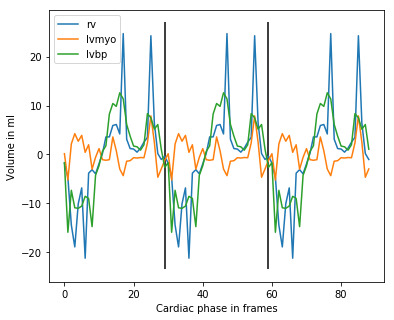

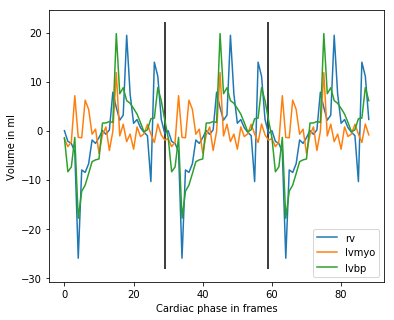

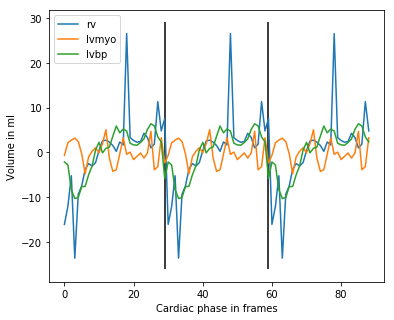

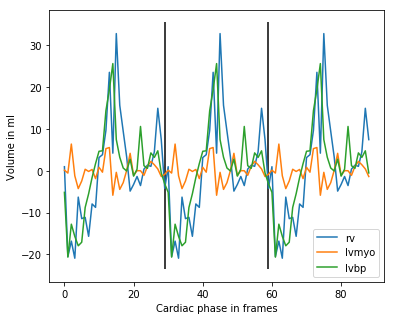

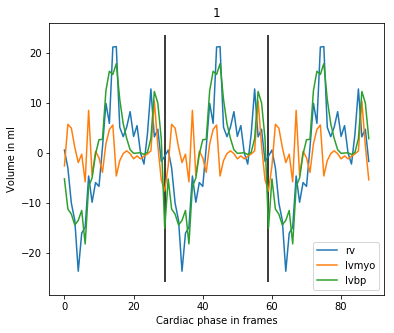

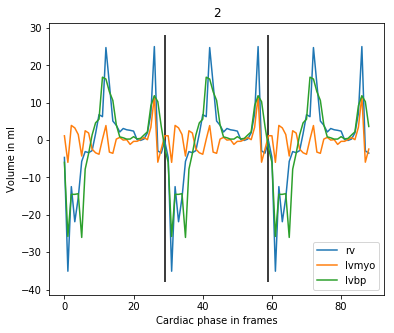

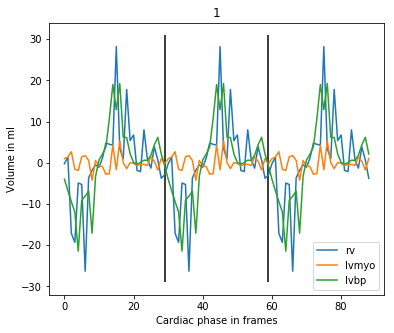

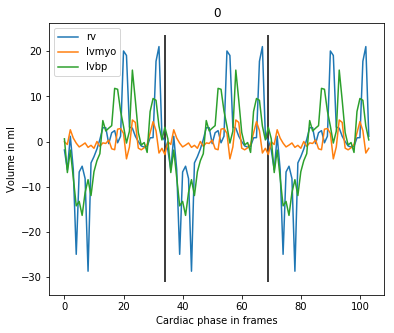

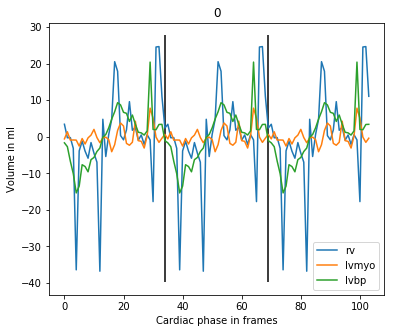

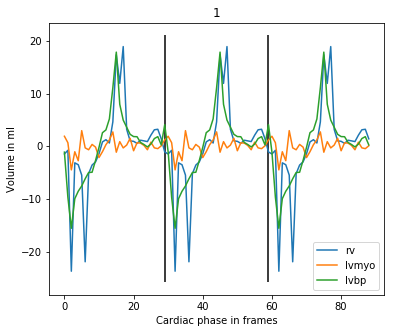

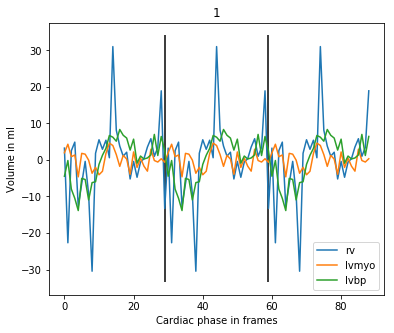

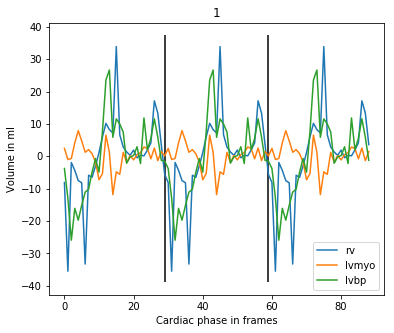

In [551]:
patids = '''90071_0
90072_0
90075_0
90086_0
NLGRO41_6_1
NLUTR18_2_2
NLUTR2_3_1
NLUTR2_5_0
NLUTR26_3_0
NLUTR64_3_1
NLUTR75_1_1
NLUTR8_2_1'''.split()

# 90079_0
# NLUTR29_3_0
# NLUTR49_3_0

features = list()
# for fname in tqdm(glob('/home/bob/CardiacMRStrain/arvc/short_axis/*.nii.gz')):
for patid in tqdm(patids):
    fname = '/home/bob/CardiacMRStrain/arvc/short_axis/{}.nii.gz'.format(patid)
    arvc_seg = ARVCSegmentation(fname)
    arvc_seg.remove_small_components()
    vp = VolumePlotter(arvc_seg, n_phases=3)
    vp.total_diff()
#     vp.slice_volumes()
#     vp.total_volumes()
#     vp.fancy_volumes('lvbp')
#     vp.fancy_volumes('rv')
#     vp.fancy_volumes('lvmyo')
#     fracs = vp.describe()
#     features.append(fracs)
#     break


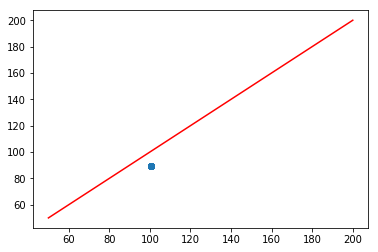

In [527]:
features = np.array(features)
plt.scatter(features[:, 0], features[:, 2])
plt.plot((50,200), (50,200), color='red')

In [502]:
fraction


0.6464719607369861